# Visualizing Price Movement

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn as sk
import statsmodels.api as sm

In [3]:
#path to the data folder, edit if necesssary
path = "./data/"

#filenames
file_power = "competitor_market_prices_power.csv"
file_gas = "competitor_market_prices_gas.csv"
master_power = "master_competitor_market_prices_power.csv"
master_gas = "master_competitor_market_prices_gas.csv"

#Price Filenames
power_prices = 'power_prices'
gas_prices = 'gas_prices'

In [4]:
#Reading in gas and power prices
df_power_prices = pd.read_csv(path + power_prices, index_col = 'Dates')
df_gas_prices = pd.read_csv(path + gas_prices, index_col = 'date')

df_power_prices

,spot_peak,spot_base,y_ahead_peak,2y_ahead_peak,3y_ahead_peak,y_ahead_base,2y_ahead_base,3y_ahead_base,d_ahead_peak,d_ahead_base,m_ahead_base,6m_ahead_base,m_ahead_peak,6m_ahead_peak
Dates,,,,,,,,,,,,,,
2000-06-16,20.503333,17.126250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-06-17,15.180000,13.297083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-06-18,12.578333,11.401667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-06-19,21.919167,17.666250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-06-20,22.856667,18.363750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-10,186.518333,162.090000,581.64,353.67,254.50,427.00,270.00,195.00,186.52,162.09,344.89,389.71,470.80,492.09
2022-10-11,291.780833,259.873750,585.40,355.50,253.50,435.64,270.00,194.92,291.78,259.87,345.31,398.27,469.67,492.92
2022-10-12,299.796667,282.535833,590.00,355.46,253.61,434.00,268.00,193.88,299.80,282.54,341.97,389.53,454.50,485.41


In [5]:
#Reading in master data
df_power = pd.read_csv(path + master_power)
df_power.set_index(pd.to_datetime(df_power['date_valid_from']), inplace = True)
df_gas = pd.read_csv(path + master_gas)
df_gas.set_index(pd.to_datetime(df_gas['date_valid_from']), inplace = True)

In [6]:
df_gas_prices.index = pd.to_datetime(df_gas_prices.index)
df_power_prices.index = pd.to_datetime(df_power_prices.index)

In [7]:
#Defining functions that subset our data for a certain consumption range, postcode and supplier name and prepares it for analysis.
#Average household prices are exploded across time period and grouped by validity dates.

def queryRangePostCode(consumption_range_kwh = 2000, post_code = 81737) -> pd.DataFrame:
    res = df_power.loc[(df_power.consumption_range_kwh == consumption_range_kwh) & (df_power.post_code == post_code)].copy()
    
    if res.shape[0] > 0:
        #Generating date indexed data
        res["valid_range"] = res.apply(lambda x: pd.date_range(x["date_valid_from"], x["date_valid_to"]), axis=1)
        res = res.explode("valid_range").copy()

        #Aggregating for mean household prices per day
        res = res.groupby('valid_range').agg({'price_year_eur':'mean'})
    return res

def queryRangeSupplier(consumption_range_kwh = 2000, supplier = 'Sarma') -> pd.DataFrame:
    res = df_power.loc[(df_power.consumption_range_kwh == consumption_range_kwh) & (df_power.supplier == supplier)].copy()

    if res.shape[0] > 0:
        #Generating date indexed data
        res["valid_range"] = res.apply(lambda x: pd.date_range(x["date_valid_from"], x["date_valid_to"]), axis=1)
        res = res.explode("valid_range").copy()

        #Aggregating for mean household prices per day
        res = res.groupby('valid_range').agg({'price_year_eur':'mean'})
    return res

def queryPostCodeSupplier(post_code = 81737, supplier = 'Sarma') -> pd.DataFrame:
    res = df_power.loc[(df_power.post_code == post_code) & (df_power.supplier == supplier)].copy()
    if res.shape[0] > 0:
        #Generating date indexed data
        res["valid_range"] = res.apply(lambda x: pd.date_range(x["date_valid_from"], x["date_valid_to"]), axis=1)
        res = res.explode("valid_range").copy()

        #Aggregating for mean household prices per day
        res = res.groupby('valid_range').agg({'price_year_eur':'mean'})
    return res

def queryPower(consumption_range_kwh = 2000, supplier = 'Sarma', post_code = 81737) -> pd.DataFrame:
    res = df_power.loc[(df_power.consumption_range_kwh == consumption_range_kwh) & (df_power.supplier == supplier) & (df_power.post_code == post_code)].copy()

    if res.shape[0] > 0:
        #Generating date indexed data
        res["valid_range"] = res.apply(lambda x: pd.date_range(x["date_valid_from"], x["date_valid_to"]), axis=1)
        res = res.explode("valid_range").copy()

        #Aggregating for mean household prices per day
        res = res.groupby('valid_range').agg({'price_year_eur':'mean'})
    return res

In [8]:
#Defining function for price time series preparation.
#price_instrument -> str specifying desired price instrument
#model_type -> str, either 'ewm' or 'sma'
#days -> int, how many days is the model looking back for sma models, and maps to alpha (by dividing by 1000) for ewm models

def selectPriceTimeSeries(price_instrument = 'y_ahead_base', model_type = 'sma', days = 100) -> pd.DataFrame:
    if model_type == 'sma':
        res = df_power_prices[price_instrument]
        res = pd.DataFrame(res.rolling(days).mean())
    else:
        days /= 1000
        res = pd.DataFrame(df_power_prices[[price_instrument]].ewm(alpha = days, adjust = False).mean())
    return res

#Defining function to get most relevant price instrument timeseries combo as measured by linear regression R-squared
#price_instruments -> list of power price instruments to try
#household data -> daily aggregated mean household data to regress upon

from sklearn.linear_model import LinearRegression

def getMostRelevantInstrument(household_data) -> str:

    #Model output which will be printed
    max_R2 = np.NAN
    best_model_type = ''
    best_model_period = 0
    best_model_instrument = np.NAN
    price_instruments = ['spot_base', 'y_ahead_base', '3y_ahead_base', 'm_ahead_base', '6m_ahead_base']

    if household_data.shape[0] == 0:
        return best_model_instrument

    household_data.set_index(pd.to_datetime(household_data.index))
    models = ['sma', 'ewm']
    times = [100, 200, 300]

    for instrument in price_instruments:
        for model in models:
            for time in times:
                timeseries = selectPriceTimeSeries(instrument, model, time)
                temp = household_data.merge(timeseries, left_index = True, right_index = True, how = 'inner')

                X = temp[[instrument]]
                Y = np.array(temp.price_year_eur)

                lm = LinearRegression()
                reg = lm.fit(X,Y)
                score = reg.score(X,Y)

                if score > max_R2:
                    max_R2 = score
                    best_model_type = model
                    best_model_instrument = instrument
                    best_model_period = time
    
    return best_model_instrument


In [9]:
#Creating df which stores most important price for top 100 suppliers across top 10 postcodes

#Getting Top 100 suppliers
df_top_suppliers = pd.DataFrame(df_power.supplier.value_counts().head(100))
df_top_suppliers.reset_index(inplace=True)
df_top_suppliers.rename(columns={'index': 'supplier', 'supplier': 'count'}, inplace=True)

#Getting Top 10 postcodes
top_postcodes = df_power.post_code.value_counts().head(10)

#Generating Post Code Columns containing most important instrument and model info for top 10 postcodes (Takes around 20 min)
for postcode in top_postcodes.index:
    print(postcode) #prints out postcode to tell you how far along the calculation is
    df_top_suppliers[postcode] = df_top_suppliers.apply(lambda x: getMostRelevantInstrument(queryPostCodeSupplier(postcode, x['supplier'])), axis = 1)

df_top_suppliers

21423
24109
48161
85055
72108
53229
76137
59071
31789
54294


,supplier,count,21423,24109,48161,85055,72108,53229,76137,59071,31789,54294
0,Sarma,1832747,m_ahead_base,m_ahead_base,m_ahead_base,m_ahead_base,m_ahead_base,m_ahead_base,m_ahead_base,m_ahead_base,m_ahead_base,m_ahead_base
1,Bergwind,1442630,m_ahead_base,m_ahead_base,m_ahead_base,m_ahead_base,m_ahead_base,m_ahead_base,m_ahead_base,m_ahead_base,m_ahead_base,m_ahead_base
2,Caurus,1342179,spot_base,y_ahead_base,y_ahead_base,spot_base,spot_base,y_ahead_base,spot_base,spot_base,y_ahead_base,spot_base
3,Pulenat,1181005,m_ahead_base,m_ahead_base,m_ahead_base,m_ahead_base,m_ahead_base,y_ahead_base,m_ahead_base,m_ahead_base,m_ahead_base,m_ahead_base
4,Belat,1136882,m_ahead_base,m_ahead_base,m_ahead_base,m_ahead_base,m_ahead_base,m_ahead_base,m_ahead_base,m_ahead_base,m_ahead_base,m_ahead_base
...,...,...,...,...,...,...,...,...,...,...,...,...
95,Himmelsbesen,19010,6m_ahead_base,6m_ahead_base,spot_base,spot_base,spot_base,spot_base,m_ahead_base,spot_base,spot_base,spot_base
96,Oroshi,16166,spot_base,3y_ahead_base,,,,6m_ahead_base,3y_ahead_base,,,
97,Maloja,15878,spot_base,spot_base,spot_base,m_ahead_base,,spot_base,spot_base,spot_base,spot_base,spot_base
98,Taifun,15340,,,,3y_ahead_base,3y_ahead_base,,m_ahead_base,,,


In [18]:
#Dropping count column and adding mode column for most important price across postcodes
df_top_suppliers.drop('count', inplace=True)
df_top_suppliers['most_important_price'] = df_top_suppliers.apply(lambda x: x.mode(dropna = True)[0], axis = 1)

In [19]:
#Adding strategy indices for suppliers
df_strat_index = pd.DataFrame(df_power.groupby('supplier').agg({'strat_index':'mean'}))
df_strat_index.reset_index(inplace=True)
df_top_suppliers = df_top_suppliers.merge(df_strat_index, on = 'supplier', how= 'left')

In [24]:
df_top_suppliers[['supplier', 'most_important_price', 'strat_index']].most_important_price.value_counts()

m_ahead_base     40
6m_ahead_base    19
spot_base        18
3y_ahead_base    11
                  7
y_ahead_base      5
Name: most_important_price, dtype: int64

In [25]:
#Getting mode model & price per postcode
df_top_postcodes = pd.DataFrame(top_postcodes)
df_top_postcodes.reset_index(inplace=True)
df_top_postcodes.rename(columns={'post_code': 'counts', 'index': 'postcode'}, inplace=True)
df_top_postcodes['mode_price'] = df_top_postcodes.apply(lambda x: df_top_suppliers[x['postcode']].mode(), axis = 1)
df_top_postcodes

,postcode,counts,mode_price
0,21423,649265,m_ahead_base
1,24109,644459,m_ahead_base
2,48161,364995,m_ahead_base
3,85055,348328,m_ahead_base
4,72108,342623,m_ahead_base
5,53229,338827,m_ahead_base
6,76137,337988,m_ahead_base
7,59071,336913,m_ahead_base
8,31789,336354,m_ahead_base
9,54294,333178,m_ahead_base


In [76]:
#Looking at periods of repricing for a certain supplier tariff consumption range postcode combo
df_repricing_test1 = df_power.loc[(df_power.consumption_range_kwh == 2000) & (df_power.supplier == 'Caurus') & (df_power.tariff == 'Seadra') & (df_power.post_code == 51103)].copy()
df_repricing_test2 = df_power.loc[(df_power.consumption_range_kwh == 2000) & (df_power.supplier == 'Caurus') & (df_power.tariff == 'Seadra') & (df_power.post_code == 21423)].copy()
df_repricing_test3 = df_power.loc[(df_power.consumption_range_kwh == 2000) & (df_power.supplier == 'Caurus') & (df_power.tariff == 'Seadra') & (df_power.post_code == 48161)].copy()

In [77]:
#Converting to daily price data
df_repricing_test1["valid_range"] = df_repricing_test1.apply(lambda x: pd.date_range(x["date_valid_from"], x["date_valid_to"]), axis=1)
df_repricing_test2["valid_range"] = df_repricing_test2.apply(lambda x: pd.date_range(x["date_valid_from"], x["date_valid_to"]), axis=1)
df_repricing_test3["valid_range"] = df_repricing_test3.apply(lambda x: pd.date_range(x["date_valid_from"], x["date_valid_to"]), axis=1)
df_repricing_test1 = df_repricing_test1.explode("valid_range").copy()
df_repricing_test2 = df_repricing_test2.explode("valid_range").copy()
df_repricing_test3 = df_repricing_test3.explode("valid_range").copy()

In [78]:
#Setting daily index and plotting price movement
df_repricing_test1.set_index('valid_range', inplace = True)
df_repricing_test2.set_index('valid_range', inplace = True)
df_repricing_test3.set_index('valid_range', inplace = True)


In [79]:
#Looking at top 3 supplier tariff combos in the top 10 postcodes
top_tariffs = pd.DataFrame(df_power.groupby(['supplier', 'tariff']).count().sort_values(by = 'date_valid_from').tail(5).index)
top_tariffs

,0
0,"(Boreas, Delphox)"
1,"(Sarma, Budew)"
2,"(Caurus, Seadra)"
3,"(Sarma, Lanturn)"
4,"(Bergwind, Tsareena)"


In [73]:
#Getting top 5 suppliers per strat index
top_tariffs_1 = df_power.loc[df_power.strat_index == 1].groupby(['supplier', 'tariff']).count().sort_values(by = 'date_valid_from').tail(5).index.tolist()
top_tariffs_1

[('Joran', 'Clefairy'),
 ('Dordogne', 'Surskit'),
 ('Talwind', 'Granbull'),
 ('Aspr', 'Runerigus'),
 ('Joran', 'Herdier')]

In [80]:
#Aggregating daily prices 
df_repricing_test1 = df_repricing_test1.groupby('valid_range').agg({'price_year_eur':'mean'})
df_repricing_test2 = df_repricing_test2.groupby('valid_range').agg({'price_year_eur':'mean'})
df_repricing_test3 = df_repricing_test3.groupby('valid_range').agg({'price_year_eur':'mean'})

<AxesSubplot: xlabel='valid_range'>

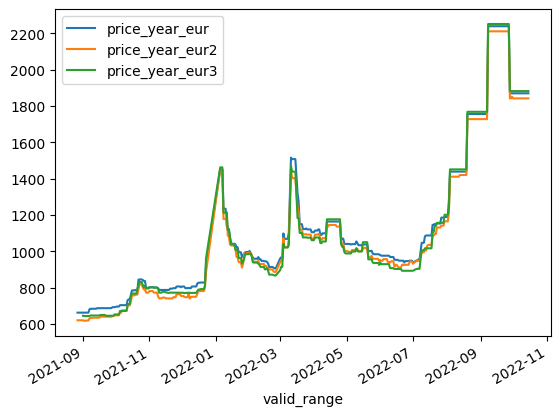

In [81]:
#Comparing same postcodes and same consumption ranges across suppliers
df_repricing_test1.join(df_repricing_test2, rsuffix = '2').join(df_repricing_test3, rsuffix= '3').plot()

In [68]:
#Looking at periods of repricing for a certain supplier tariff consumption range postcode combo
df_repricing_test1 = df_power.loc[(df_power.consumption_range_kwh == 2000) & (df_power.supplier == 'Sarma') & (df_power.tariff == 'Lanturn') & (df_power.post_code == 51103)].copy()
df_repricing_test2 = df_power.loc[(df_power.consumption_range_kwh == 1500) & (df_power.supplier == 'Sarma') & (df_power.tariff == 'Lanturn') & (df_power.post_code == 51103)].copy()
df_repricing_test3 = df_power.loc[(df_power.consumption_range_kwh == 2500) & (df_power.supplier == 'Sarma') & (df_power.tariff == 'Lanturn') & (df_power.post_code == 51103)].copy()
df_repricing_test4 = df_power.loc[(df_power.consumption_range_kwh == 6000) & (df_power.supplier == 'Sarma') & (df_power.tariff == 'Lanturn') & (df_power.post_code == 51103)].copy()
df_repricing_test5 = df_power.loc[(df_power.consumption_range_kwh == 8000) & (df_power.supplier == 'Sarma') & (df_power.tariff == 'Lanturn') & (df_power.post_code == 51103)].copy()

In [69]:
#Converting to daily price data
df_repricing_test1["valid_range"] = df_repricing_test1.apply(lambda x: pd.date_range(x["date_valid_from"], x["date_valid_to"]), axis=1)
df_repricing_test2["valid_range"] = df_repricing_test2.apply(lambda x: pd.date_range(x["date_valid_from"], x["date_valid_to"]), axis=1)
df_repricing_test3["valid_range"] = df_repricing_test3.apply(lambda x: pd.date_range(x["date_valid_from"], x["date_valid_to"]), axis=1)
df_repricing_test4["valid_range"] = df_repricing_test4.apply(lambda x: pd.date_range(x["date_valid_from"], x["date_valid_to"]), axis=1)
df_repricing_test5["valid_range"] = df_repricing_test5.apply(lambda x: pd.date_range(x["date_valid_from"], x["date_valid_to"]), axis=1)

df_repricing_test1 = df_repricing_test1.explode("valid_range").copy()
df_repricing_test2 = df_repricing_test2.explode("valid_range").copy()
df_repricing_test3 = df_repricing_test3.explode("valid_range").copy()
df_repricing_test4 = df_repricing_test4.explode("valid_range").copy()
df_repricing_test5 = df_repricing_test5.explode("valid_range").copy()

#Setting daily index and plotting price movement
df_repricing_test1.set_index('valid_range', inplace = True)
df_repricing_test2.set_index('valid_range', inplace = True)
df_repricing_test3.set_index('valid_range', inplace = True)
df_repricing_test4.set_index('valid_range', inplace = True)
df_repricing_test5.set_index('valid_range', inplace = True)

#Aggregating daily prices 
df_repricing_test1 = df_repricing_test1.groupby('valid_range').agg({'price_year_eur':'mean'})
df_repricing_test2 = df_repricing_test2.groupby('valid_range').agg({'price_year_eur':'mean'})
df_repricing_test3 = df_repricing_test3.groupby('valid_range').agg({'price_year_eur':'mean'})
df_repricing_test4 = df_repricing_test4.groupby('valid_range').agg({'price_year_eur':'mean'})
df_repricing_test5 = df_repricing_test5.groupby('valid_range').agg({'price_year_eur':'mean'})

<AxesSubplot: xlabel='valid_range'>

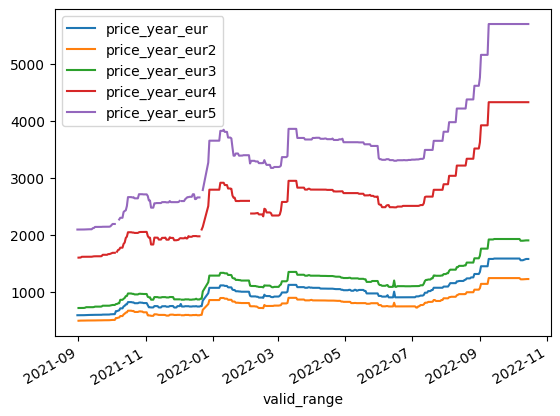

In [70]:
df_repricing_test1.join(df_repricing_test2, rsuffix = '2').join(df_repricing_test3, rsuffix= '3').join(df_repricing_test4, rsuffix= '4').join(df_repricing_test5, rsuffix= '5').plot()